In [ ]:
!pip install transformers==4.34.0
!pip install bitsandbytes
!pip install accelerate
!pip install peft==0.6.1
!pip install neptune
!pip install language-tool-python

  Obtaining dependency information for transformers==4.34.0 from https://files.pythonhosted.org/packages/1a/d1/3bba59606141ae808017f6fde91453882f931957f125009417b87a281067/transformers-4.34.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 62.1 MB/s eta 0:00:0000:0100:01


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from transformers import get_cosine_schedule_with_warmup, BitsAndBytesConfig
from sklearn.model_selection import KFold, train_test_split
from transformers import DataCollatorWithPadding
import peft
from peft import LoraConfig, get_peft_model
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm
from torch.utils.data import ConcatDataset
import uuid
import neptune
import time
import language_tool_python
import pickle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Mapping

In [3]:
mapping = {-1: "Unknown", 0: "Car-free cities", 1: "Does the electoral college work?", 
           2: "Exploring Venus", 3: "The Face on Mars", 4: "Facial action coding system", 
           5: "Seeking multiple opinions", 6: "Phones and driving"}

def encode(x):
    return mapping.get(x, 'Unknown') 

#llm-detect-ai-generated-text
data = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
data['id'] = data['id'] + '_original'

# llm-generated-essays
new_data = pd.read_csv('/kaggle/input/llm-generated-essays/ai_generated_train_essays.csv')
new_data['id'] = new_data['id'] + '_ai_generated'
data = pd.concat([data, new_data])

new_data = pd.read_csv('/kaggle/input/llm-generated-essays/ai_generated_train_essays_gpt-4.csv')
new_data['id'] = new_data['id'] + '_ai_generated_gpt-4'
data = pd.concat([data, new_data])

# llm-7-prompt-training-dataset
'''
new_data = pd.read_csv('/kaggle/input/llm-7-prompt-training-dataset/train_essays_7_prompts_v2.csv')
new_data.rename(columns={'label': 'generated'}, inplace=True)
generated_ids = [uuid.uuid4().hex[:8] for _ in range(len(new_data))]
new_data['id'] = generated_ids
new_data['prompt_id'] = -1
new_data['id'] = new_data['id'] + '_7_prompt_v2'
data = pd.concat([data, new_data])
'''
'''
new_data = pd.read_csv('/kaggle/input/llm-7-prompt-training-dataset/train_essays_RDizzl3_seven_v2.csv')
new_data.rename(columns={'label': 'generated'}, inplace=True)
generated_ids = [uuid.uuid4().hex[:8] for _ in range(len(new_data))]
new_data['id'] = generated_ids
new_data['prompt_id'] = -1
new_data['id'] = new_data['id'] + '_7_prompt_RDizzl3_v2'
data = pd.concat([data, new_data])
'''

# daigt
new_data = pd.read_csv('/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv')
new_data_generated = new_data[['source_text']].copy()
new_data_generated.rename(columns={'source_text': 'text'}, inplace=True)
new_data_student = new_data[['text']].copy()
new_data_generated['generated'] = 1
new_data_student['generated'] = 0
generated_ids = [uuid.uuid4().hex[:8] for _ in range(len(new_data_generated))]
new_data_generated['id'] = generated_ids
new_data_generated['id'] = new_data_generated['id'] + '_daigt'
generated_ids = [uuid.uuid4().hex[:8] for _ in range(len(new_data_student))]
new_data_student['id'] = generated_ids
new_data_student['id'] = new_data_student['id'] + '_daigt'
new_data_generated['prompt_id'] = -1
new_data_student['prompt_id'] = -1
data = pd.concat([data, new_data_student])
data = pd.concat([data, new_data_generated])

data['prompt_id'] = data['prompt_id'].apply(encode)

# daigt falcon and llama
'''
new_data = pd.read_csv('/kaggle/input/daigt-data-llama-70b-and-falcon180b/llama_falcon_v3.csv')
generated_ids = [uuid.uuid4().hex[:8] for _ in range(len(new_data))]
new_data['id'] = generated_ids
new_data['id'] = new_data['id'] + '_daigt_falcon_lamma'
new_data.rename(columns={'prompt_name': 'prompt_id'}, inplace=True)
new_data.drop(['model'], axis=1)
data = pd.concat([data, new_data])
'''

# correct typos and spelling errors
tool = language_tool_python.LanguageTool('en-US')

# Clip the text - we use 62 max token length -> 600 chars should suffice
data['text'] = data['text'].apply(lambda x: x[:600])

def correct(x):
    return tool.correct(x)

tqdm.pandas()
data['text'] = data['text'].progress_apply(correct)

# Set random permutation
np.random.seed(42)
perm = np.random.permutation(len(data))
data = data.iloc[perm].reset_index(drop=True)
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

data.to_csv('train_full.csv', index=False)
train_data.to_csv('train.csv', index=False)
val_data.to_csv('val.csv', index=False)

test_data = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
test_data['prompt_id'] = test_data['prompt_id'].apply(encode)
test_data.to_csv('test.csv')

In [4]:
print(f'Number of human essays in train: {data[data["generated"] == 0].shape[0]}')
print(f'Number of LLM generated essays in train: {data[data["generated"] == 1].shape[0]}')

Number of human essays in train: 3796
Number of LLM generated essays in train: 3124


In [5]:
data['prompt_id'].value_counts()

prompt_id
Unknown                             4842
Car-free cities                     1058
Does the electoral college work?    1020
Name: count, dtype: int64

## Custom Dataset (with tokenizer)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, backbone, path, max_length, text_col, sep=',', id_col=None, target_col=None, 
                 cat_col=None, sample=None, tokenizer=None) -> None:
        super().__init__()
        df = pd.read_csv(path, sep=sep)
        if sample:
            df = df.sample(sample)
        self.tokenizer = None
        if tokenizer:
            self.tokenizer = AutoTokenizer.from_pretrained(tokenizer)
        if not tokenizer:
            self.tokenizer = AutoTokenizer.from_pretrained(backbone)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        # self.collator = DataCollatorWithPadding(self.tokenizer, padding=True)
        self.tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = True
        self.ids = df[id_col].values.tolist() if id_col in df.columns else None
        self.texts = None
        if text_col in df.columns:
            if cat_col in df.columns:
                df[text_col] = df[cat_col] + ' [SEP] ' + df[text_col]
            self.texts = df[text_col].values.tolist()
        self.labels = df[target_col].values.tolist() if target_col in df.columns else None
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        r = self.tokenizer(
            text=self.texts[index],
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt',
            padding="max_length",
        )
        r = {k : v[0] for k, v in r.items()}
        if self.labels:
            r['labels'] = self.labels[index]
        r['ids'] = self.ids[index]
        return r

## Classification model

In [7]:
class ClassHead(nn.Module):
    def __init__(self, input_dim, num_outputs):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_outputs)

    def forward(self, x):
        return self.linear(x)
    
class Pooling(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        
    def forward(self, x, attention_mask):
        mean_pooled_batch = torch.zeros(x.shape[0], x.shape[2], device=self.device)
        for i in range(attention_mask.shape[0]):
            masked_embeddings = x[i] * attention_mask[i, :, None]
            mean_pooled_batch[i] = torch.sum(masked_embeddings, axis=0) / torch.sum(attention_mask[i])
        return mean_pooled_batch
    
class ClassificationModel(nn.Module):
    def __init__(self, backbone, device, num_outputs, quantization_config=None, lora_config=None):
        super().__init__()
        self.backbone = None
        if quantization_config and lora_config:
            if type(backbone) == str:
                model = AutoModel.from_pretrained(backbone, quantization_config=quantization_config)
            else: 
                model = backbone
            self.backbone = get_peft_model(model, lora_config)           
        else:
            if type(backbone) == str:
                self.backbone = AutoModel.from_pretrained(backbone)
            else:
                self.backbone = backbone
        self.num_outputs = num_outputs
        self.hidden_dim = self.backbone.config.hidden_size
        self.device = device
        self.pooling = Pooling(self.device)
        self.head = ClassHead(self.hidden_dim, num_outputs)
    
    def forward(self, x, apply_softmax=False):
        attention_mask = x['attention_mask']
        x = self.backbone(**x)['last_hidden_state']
        x = self.pooling(x, attention_mask)
        x = self.head(x)
        if self.num_outputs == 1:
            x = x.view(-1)
        if apply_softmax:
            x = nn.functional.softmax(x, dim=1)
        return x 

## Arguments/hyper-parameters

In [8]:
class Args:
    def __init__(self, backbone, lr_back=5e-5, lr_head=5e-5, max_length=62, epochs=4,
                batch_size=16, device='cuda', val_metrics=[roc_auc_score, accuracy_score], 
                 loss=nn.MSELoss(), sample=None, quantization_config=None, lora_config=None,
                num_outputs=None, use_both=False, kfold=False, num_splits=4, only_final=False,
                warmup=0, task_type=None, grad_acc=1, neptune=False):
        self.backbone = backbone
        self.lr_back = lr_back
        self.lr_head = lr_head
        self.max_length = max_length
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device
        self.val_metrics = val_metrics
        self.loss = loss
        self.sample = sample
        self.quantization_config = quantization_config
        self.lora_config = lora_config
        self.num_outputs=num_outputs
        self.use_both = use_both
        self.kfold = kfold
        self.num_splits = num_splits
        self.only_final = only_final
        self.warmup = warmup
        self.task_type = task_type
        self.grad_acc = grad_acc
        self.neptune = neptune

## Multiple schedulers

In [9]:
def configure_optimizers(model, lr_back, lr_head):
    params = list(model.named_parameters())

    def is_backbone(n): 
        return 'backbone' in n

    grouped_parameters = [
        {"params": [p for n, p in params if is_backbone(n)], 'lr': lr_back},
        {"params": [p for n, p in params if not is_backbone(n)], 'lr': lr_head},
    ]

    optimizer = torch.optim.AdamW(
        grouped_parameters, lr=lr_back
    )

    return optimizer

## Set-up of backbone

In [10]:

backbone = "mistralai/Mistral-7B-v0.1"
quantization_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.float16,
)

file_path = '/kaggle/working/quantization_config.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(quantization_config, file)
    
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj",
        "v_proj"
    ],
    lora_dropout=0.05, 
    bias="none",
)


## Classification training/inference loops

In [11]:
def class_train_loop(train_dl, model, loss_fn, optimizer, scheduler, device, grad_acc, run, log_every=1):
    losses = []
    lr_values = []
    size = len(train_dl)

    model.train()

    scaler = GradScaler()
    
    pbar = tqdm(train_dl)
    for batch_idx, batch_dict in enumerate(pbar):
        with torch.autocast(device_type=device):
            y = batch_dict["labels"].float().to(device)
            del batch_dict['labels']
            del batch_dict['ids']
            x = batch_dict
            x = {k:v.to(device) for k, v in x.items()}
            
            pred = model(x)
            loss = loss_fn(pred, y) / grad_acc

        scaler.scale(loss).backward()

        if (batch_idx + 1) % grad_acc == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
        
        if batch_idx % log_every == 0:
            losses.append(loss.detach().cpu().item())
            lr_values.append(scheduler.get_lr()[0])
            if run:
                run['train/loss'].append(losses[-1])
                run['train/lr'].append(lr_values[-1])
        
        loss, current = loss.item(), (batch_idx + 1)
        pbar.set_description(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return losses, lr_values

def class_inference_loop(model, dataloader, device, **predict_kwargs):
    model.to(device)
    predictions = []
    probs = []
    labels = []
    ids = []
    
    model.eval()
    
    with torch.no_grad(), torch.autocast(device_type=device):
        for batch_dict in tqdm(dataloader):
            y = None
            if 'labels' in batch_dict:
                y = batch_dict["labels"].float().to(device)
            tmp_ids = batch_dict['ids']
            del batch_dict['labels']
            del batch_dict['ids']
            x = batch_dict
            x = {k:v.to(device) for k, v in x.items()}
            
            logits = model(x, **predict_kwargs)
            prob = nn.functional.sigmoid(logits)
            pred = torch.where(logits < 0, torch.tensor(0), torch.tensor(1))
            predictions.extend(pred.cpu().tolist())
            probs.extend(prob.cpu().tolist())
            ids.extend(tmp_ids)
            if y is not None:
                labels.extend(y.cpu().tolist())  
    return predictions, probs, labels, ids

def validation_loop(val_dl, model, val_metrics, device):
    predictions, probs, labels, ids = class_inference_loop(model, val_dl, device)
    incorrect = {}
    indeces = [i for i in range(len(predictions)) if predictions[i] != labels[i]]
    incorrect['ids']= [ids[i] for i in indeces]
    incorrect['probs'] = [probs[i] for i in indeces]
    incorrect['labels'] = [labels[i] for i in indeces]
    scores = {}
    for metric in val_metrics:
        if metric.__name__ == 'roc_auc_score':
            scores[metric.__name__] = metric(labels, probs)
        else :
            scores[metric.__name__] = metric(labels, predictions)
    return scores, incorrect

def predict(model, test_dl, device):
    model.to(device)
    predictions = None
    predictions, _, _ = class_inference_loop(model, test_dl, device, apply_softmax=True)
    return predictions

def train(model, train_dl, val_dl, optimizer, scheduler, only_final, args, run):
    scores = []
    losses = []
    lr_rates = []
    incorrect = {'ids': [], 'probs': [], 'labels': []}
    
    model.to(args.device)
    
    for epoch in range(args.epochs):
        print(f"Epoch {epoch+1}/{args.epochs}\n-------------------------------")
        epoch_losses, epoch_lr_rates = None, None
        epoch_losses, epoch_lr_rates = class_train_loop(train_dl, model, args.loss, optimizer, 
                                                        scheduler, args.device, args.grad_acc,
                                                        run)
        if val_dl:
            if (not only_final) or (only_final and epoch == args.epochs - 1):
                epoch_scores, tmp_incorrect = validation_loop(val_dl, model, args.val_metrics, args.device)
                if run:
                    run['val/accuracy'].append(epoch_scores['accuracy_score'])
                    run['val/roc'].append(epoch_scores['roc_auc_score'])
                scores.append(epoch_scores)
                incorrect['ids'].extend(tmp_incorrect['ids'])
                incorrect['probs'].extend(tmp_incorrect['probs'])
                incorrect['labels'].extend(tmp_incorrect['labels'])
        losses.extend(epoch_losses)
        lr_rates.extend(epoch_lr_rates)
    print("Done!")
    return model, scores, losses, lr_rates, incorrect

## Data preprocessing, model saving and task selection

In [12]:
def perform_task(args):
    run = None
    if args.neptune:
        start_time = time.time()
        run = neptune.init_run(
            project="slavivo/detect-ai-text",
            api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkOTMxMmQ1NS1mZmVhLTQ2YmQtOWIxYi04MjUxNzhkZjE2MzMifQ==",
            tags=[args.task_type, args.backbone]
        )
        params = {key:value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(key)}
        params['val_metrics'] = [metric.__name__ for metric in params['val_metrics']]
        del params['neptune']
        params['loss'] = params['loss'].__class__.__name__
        run["parameters"] = params
    model = ClassificationModel(args.backbone, args.device, args.num_outputs, args.quantization_config, 
                                args.lora_config)
    
    train_dl, val_dl = None, None
    if args.use_both:
        train_ds = CustomDataset(args.backbone, '/kaggle/working/train_full.csv', args.max_length, 
                                 text_col='text', sep=',', id_col='id', target_col='generated', 
                                 cat_col=None, sample=args.sample)
        train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
    else:
        train_ds = CustomDataset(args.backbone, '/kaggle/working/train.csv', args.max_length, 
                                 text_col='text', sep=',', id_col='id', target_col='generated', 
                                 cat_col=None, sample=args.sample)
        val_ds = CustomDataset(args.backbone, '/kaggle/working/val.csv', args.max_length, 
                               text_col='text', sep=',', id_col='id', target_col='generated', 
                               cat_col=None, sample=args.sample)
        train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
        val_dl = DataLoader(val_ds, batch_size=args.batch_size, shuffle=False)

    optimizer = configure_optimizers(model, args.lr_back, args.lr_head)

    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dl)*args.warmup, 
                                                num_training_steps=(args.epochs * len(train_dl)) // args.grad_acc)
    model, val_scores, train_losses, lr_rates, incorrect = train(model, train_dl, val_dl, optimizer, scheduler, args.only_final, args, run)

    prefix = args.task_type
    model.backbone.save_pretrained(f'{prefix}_model')
    train_ds.tokenizer.save_pretrained(f'{prefix}_tokenizer')
    torch.save(model.head.state_dict(), f'{prefix}_head.pth')

    pd.DataFrame({"train loss":train_losses}).plot(xlabel="step", ylabel="loss", style="-", title="Train")

    if not args.use_both and not args.only_final:
        pd.DataFrame(val_scores).plot(xlabel="epoch", ylabel="score", style="o-", title="Validation")
        plt.show()
        df = pd.DataFrame(incorrect)
        df['ids'] = df['ids'].str.split('_', n=1).str[1]
        sns.countplot(data=df, x='ids')
        plt.show()
        sns.countplot(data=df, x='labels')
        plt.show()
        sample = min(len(df), 20)
        df = df.sample(sample)
        probs = df["probs"].tolist()
        probs = [round(prob, 2) for prob in probs]
        labels = df["labels"].tolist()
        print(f'Sample of incorrect probabilities: {probs}')
    if args.only_final:
        print(val_scores)
        
    if args.neptune:
        end_time = time.time()
        run["time"] = f'{end_time - start_time:.2f} s'
        run.stop()
        
    return model

## Encoder-based training

In [13]:
'''
class_args = Args(backbone = 'microsoft/deberta-v3-base', task_type='encoder', lr_back = 3e-5, 
            lr_head = 5e-5, max_length = 64, epochs = 3, batch_size = 32, device = 'cuda', 
            val_metrics = [accuracy_score, roc_auc_score], loss = nn.BCEWithLogitsLoss(), sample = None, 
            num_outputs=1, use_both = True, kfold = False, num_splits = 4, only_final = False,
            warmup=1/10, grad_acc=1, neptune=False)

model = perform_task(class_args)
torch.cuda.empty_cache()
'''

"\nclass_args = Args(backbone = 'microsoft/deberta-v3-base', task_type='encoder', lr_back = 3e-5, \n            lr_head = 5e-5, max_length = 64, epochs = 3, batch_size = 32, device = 'cuda', \n            val_metrics = [accuracy_score, roc_auc_score], loss = nn.BCEWithLogitsLoss(), sample = None, \n            num_outputs=1, use_both = True, kfold = False, num_splits = 4, only_final = False,\n            warmup=1/10, grad_acc=1, neptune=False)\n\nmodel = perform_task(class_args)\ntorch.cuda.empty_cache()\n"

## Decoder-based training

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch 1/1
-------------------------------


loss: 1.117316  [    1/    1]: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


Done!


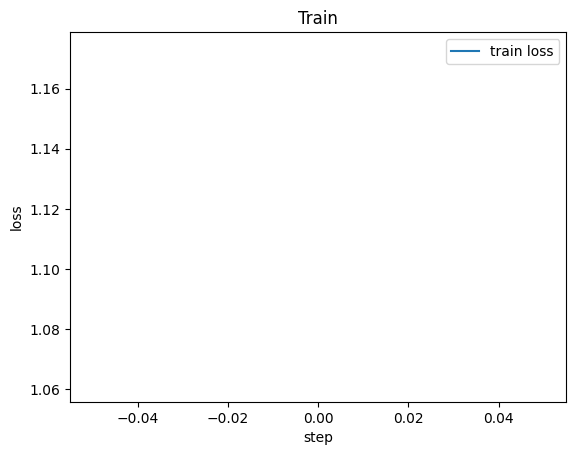

In [14]:

class_args = Args(backbone = 'mistralai/Mistral-7B-v0.1', task_type='decoder', lr_back = 5e-5, 
            lr_head = 5e-5, max_length = 62, epochs = 1, batch_size = 16, device = 'cuda', 
            val_metrics = [roc_auc_score, accuracy_score], loss = nn.BCEWithLogitsLoss(), sample = None, 
            quantization_config=quantization_config, lora_config=lora_config, num_outputs=1,
            use_both = True, kfold = False, num_splits = 4, only_final = False, warmup=1/10,
            grad_acc=1, neptune=False)

perform_task(class_args)
torch.cuda.empty_cache()